In this file we include the solution for the entorpy potential

In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.tensorboard import SummaryWriter

import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from models_v2 import *
from torchcfm.utils import *
from torchcfm.optimal_transport import OTPlanSampler

import scipy as sp

from tqdm import tqdm
import imageio
from utils_hf import *

savedir = "models/entropy_pot_8gauss_moon"
os.makedirs(savedir, exist_ok=True)


In [2]:
sigma = np.array([.5])

In [3]:
s = -2*np.log(sigma)*(1+2)

In [4]:
std_p = lambda t,x: -np.sqrt(2*np.log(x)+s)

std = sp.integrate.solve_ivp(std_p, [0,1], sigma, t_eval=np.linspace(0,1,1000),dense_output=True)

std_f = lambda t: std.sol(t).reshape(len(t))

std_prime_f = lambda t: np.sqrt(2*np.log(std_f(t))+s)

/tmp/ipykernel_1571967/2231027792.py:1: RuntimeWarning: invalid value encountered in sqrt
  std_p = lambda t,x: -np.sqrt(2*np.log(x)+s)


In [5]:
std_f([1])

array([0.125])

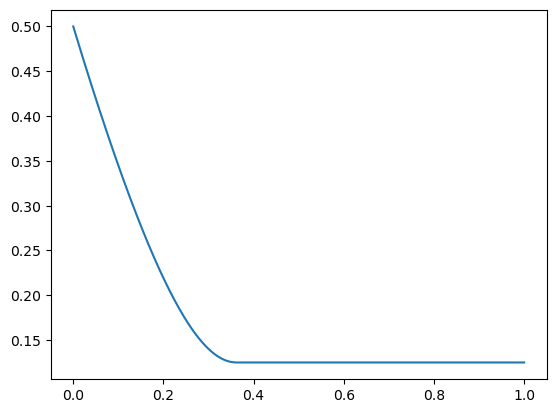

In [6]:
t = np.linspace(0,1,1000)
plt.plot(t,std_f(t))

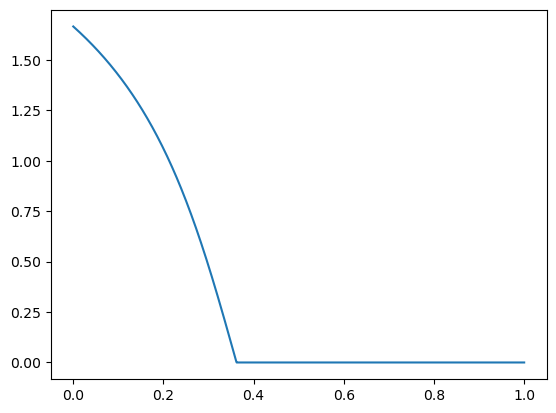

In [7]:
t = np.linspace(0,1,1000)
plt.plot(t,std_prime_f(t))

In [17]:
# Problem set up

dim = 2
batch_size = 256
n_iters = 20_000
architecture = 'MLP'
ot_sampler = OTPlanSampler(method="exact")

In [18]:
if architecture == 'ResNet':
    model_entropy = ResNet(dim= dim,w=64,time_varying= True)
else: 
    model_entorpy = MLP(dim= dim,w=64,time_varying= True)
optimizer = torch.optim.Adam(model_entropy.parameters(), lr=1e-3)

  0%|          | 0/20000 [00:00<?, ?it/s]

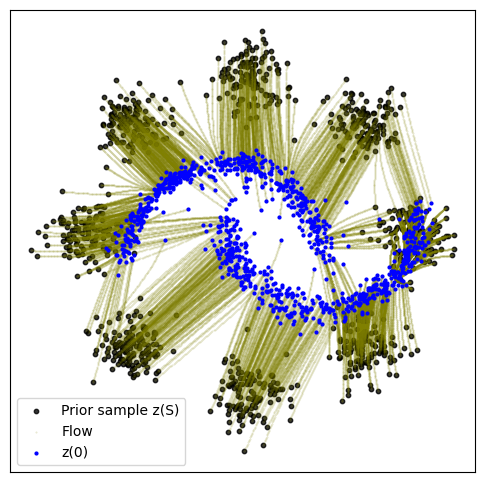

 25%|██▍       | 4995/20000 [01:30<04:41, 53.30it/s]

<Figure size 640x480 with 0 Axes>

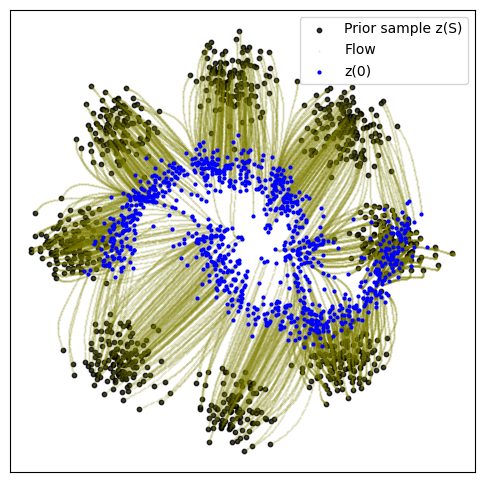

 50%|████▉     | 9997/20000 [03:01<03:39, 45.59it/s]

<Figure size 640x480 with 0 Axes>

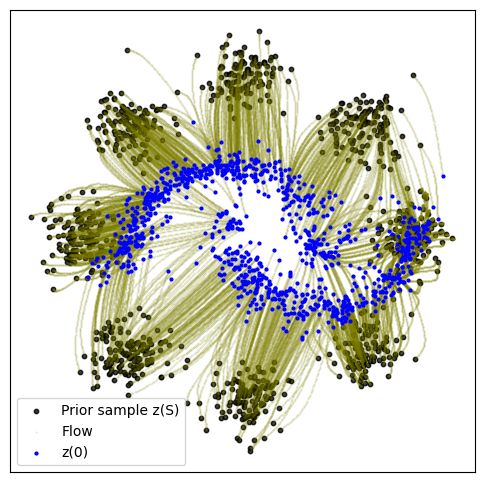

 75%|███████▍  | 14996/20000 [04:48<01:31, 54.46it/s]

<Figure size 640x480 with 0 Axes>

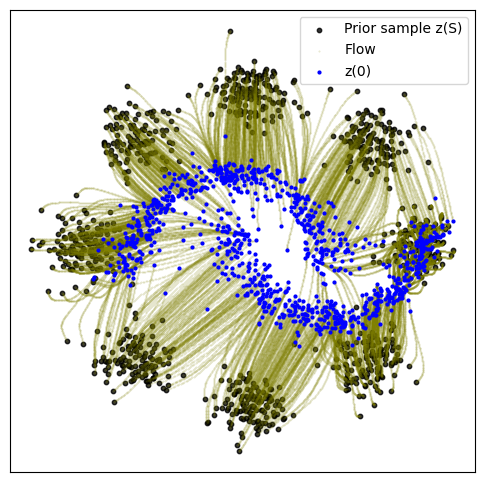

100%|██████████| 20000/20000 [06:23<00:00, 52.11it/s]


<Figure size 640x480 with 0 Axes>

In [65]:
pbar = tqdm(total=n_iters, desc="Training")
writer = SummaryWriter()
for k in tqdm(range(n_iters)):
    optimizer.zero_grad()

    t = torch.rand((batch_size,1))

    # #x0 = ref_dist.sample((batch_size,))
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    x0, x1 = ot_sampler.sample_plan(x0, x1)

    x0 = x0
    x1 = x1
    
    mu_t = ((1-t)*x0+t*x1)
    mu_t_prime = (x1-x0)

    sig_t = torch.from_numpy(std_f(t.squeeze(-1))).float().to(x0.device).unsqueeze(-1)

    sig_t_prime = torch.from_numpy(std_prime_f(t.squeeze(-1))).float().to(x0.device).unsqueeze(-1)
    epsilon = torch.randn_like(x0)
    
    xt = mu_t + sig_t*epsilon
    ut = sig_t_prime*(xt-mu_t)/(sig_t+1e-8) + mu_t_prime

    # t,xt,ut = FM.sample_location_and_conditional_flow(x0, x1)

    # print(t.shape,xt.shape,ut.shape)

    vt = model_entropy(torch.cat([xt,t],dim = -1))
    # loss = torch.mean(torch.norm(vt - ut)**2)
    loss = torch.nn.MSELoss()(vt,ut)
    writer.add_scalar('Loss', loss.item(), k)

    # Update the progress bar
    pbar.set_description("Loss: %.3f" % loss.item())
    pbar.update()
    

    loss.backward()
    optimizer.step()

    if (k ) % 5000 == 0:
        node = NeuralODE(
            torch_wrapper(model_entropy), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            # print(loss.item())
            traj = node.trajectory(
                #ref_dist.sample((1000,)),
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())
            plt.savefig(f"{savedir}/traj_{k}.png")


In [77]:
node = NeuralODE(torch_wrapper(model_entropy), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
with torch.no_grad():
    traj = node.trajectory(
                #ref_dist.sample((1000,)),
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 550),
            )
    plt.close()
#     plot_trajectories(traj.cpu().numpy())
    
#     plt.savefig(f"{savedir}/traj_final.png")

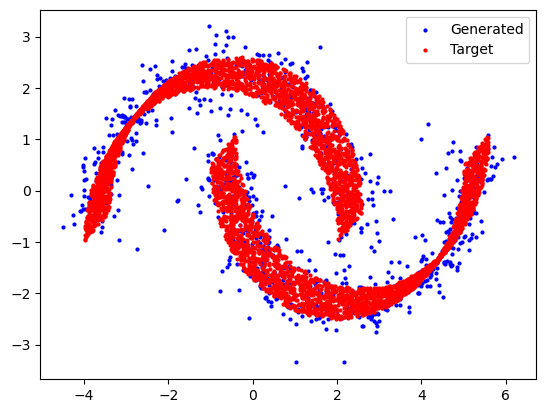

In [78]:
n = 2000
plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
samples = sample_moons(5000)
plt.scatter(samples[:, 0], samples[:, 1], s=4, alpha=1, c="red")
plt.legend(["Generated", "Target"])
plt.show()

In [72]:
torch.save(model_entropy.state_dict(), os.path.join(savedir, f"entropy_model_{architecture}_8g_moons_25000.pt"))

In [20]:
state_dict = torch.load(os.path.join(savedir, f"entropy_model_{architecture}_8g_moons_25000.pt"))

model_entropy.load_state_dict(state_dict)

<All keys matched successfully>

In [21]:
num_samples = 1000
xx0 = sample_8gaussians(num_samples)
gif_quiver(model_entropy,savedir,xx0,num_samples,N = 50)